# Test web application locally


This notebook pulls some images and tests them against the local web app running inside the Docker container we made previously.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from testing_utilities import *
import requests

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
image_name = "fboylu/kerasnasm-gpu"

Run the Docker conatainer in the background and open port 80. Notice we are using nvidia-docker and not docker command.

In [3]:
%%bash --bg -s "$image_name"
nvidia-docker run -p 80:80 $1

Starting job # 0 in a separate thread.


Wait a few seconds for the application to spin up and then check that everything works.

In [4]:
!curl 'http://0.0.0.0:80/'

Healthy

In [5]:
!curl 'http://0.0.0.0:80/version'

1.6.0

Pull an image of a Lynx to test our local web app with.

In [6]:
IMAGEURL = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg"

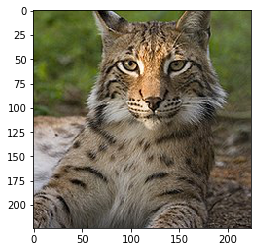

In [7]:
plt.imshow(to_img(IMAGEURL))

In [8]:
jsonimg = img_url_to_json(IMAGEURL)
jsonimg[:100] 

'{"input": "{\\"image\\": \\"iVBORw0KGgoAAAANSUhEUgAAAOAAAADgCAIAAACVT/22AAABJGlDQ1BJQ0MgUHJvZmlsZQAAeJx'

In [9]:
headers = {'content-type': 'application/json'}
%time r = requests.post('http://0.0.0.0:80/score', data=jsonimg, headers=headers)
print(r)
r.json()

CPU times: user 5.68 ms, sys: 0 ns, total: 5.68 ms
Wall time: 3.61 s
<Response [200]>


{'result': "([{'image': [('n02127052', 'lynx', 0.94087374), ('n02124075', 'Egyptian_cat', 0.004909557), ('n02123159', 'tiger_cat', 0.001938228)]}], 'Computed in 3604.97 ms')"}

Let's try a few more images.

In [10]:
images = ('https://upload.wikimedia.org/wikipedia/commons/thumb/6/68/Lynx_lynx_poing.jpg/220px-Lynx_lynx_poing.jpg',
          'https://upload.wikimedia.org/wikipedia/commons/3/3a/Roadster_2.5_windmills_trimmed.jpg',
          'http://www.worldshipsociety.org/wp-content/themes/construct/lib/scripts/timthumb/thumb.php?src=http://www.worldshipsociety.org/wp-content/uploads/2013/04/stock-photo-5495905-cruise-ship.jpg&w=570&h=370&zc=1&q=100',
          'http://yourshot.nationalgeographic.com/u/ss/fQYSUbVfts-T7pS2VP2wnKyN8wxywmXtY0-FwsgxpiZv_E9ZfPsNV5B0ER8-bOdruvNfMD5EbP4SznWz4PYn/',
          'https://cdn.arstechnica.net/wp-content/uploads/2012/04/bohol_tarsier_wiki-4f88309-intro.jpg',
          'http://i.telegraph.co.uk/multimedia/archive/03233/BIRDS-ROBIN_3233998b.jpg')

In [11]:
url = 'http://0.0.0.0:80/score'
results = [requests.post(url, data=img_url_to_json(img), headers=headers) for img in images]

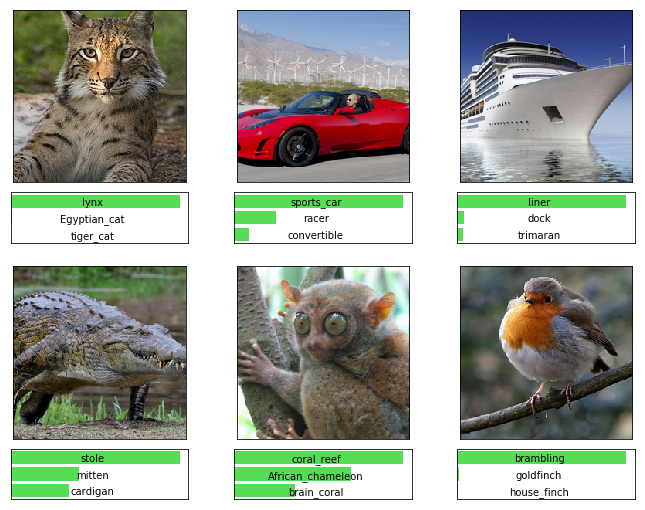

In [12]:
plot_predictions_dict(images, results)

Next let's quickly check what the request response performance is for the locally running Docker container.

In [13]:
image_data = list(map(img_url_to_json, images)) # Retrieve the images and data

In [14]:
timer_results = list()
for img in image_data:
    res=%timeit -r 1 -o -q requests.post(url, data=img, headers=headers)
    timer_results.append(res.best)

In [15]:
timer_results

[0.04808630549814552,
 0.043532381486147645,
 0.04366554080042988,
 0.04621760630980134,
 0.044019158883020285,
 0.0444298465969041]

In [16]:
print('Average time taken: {0:4.2f} ms'.format(10**3 * np.mean(timer_results)))

Average time taken: 44.99 ms


In [17]:
%%bash
docker stop $(docker ps -q)

0d79fb546f11


We can now [deploy our web application on AKS](04_DeployOnAKS.ipynb).